In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import torchaudio
import torch
import librosa
import numpy as np
import pywt
import librosa.display
from audiomentations import Normalize
from typing import Tuple
from scipy.fft import rfft, rfftfreq
from scipy import signal

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [5]:
def create_propor_train_dataframe(
    path: str
) -> pd.DataFrame:
    """
    Creates a PROPOR 2022's pandas DataFrame containing
    all the training files using the same structure as the
    `test_ser_metadata.csv` file.
    
    Args:
        path (str): the path to the CSV file.
    
    Returns:
        df (pd.DataFrame): the pandas DataFrame.
    """
    wav_files = [
        file
        for file in os.listdir(path)
        if file.endswith(".wav")
    ]
    df = pd.DataFrame()
    
    for wav in wav_files:
        wav_file = os.path.basename(wav)
        wav_file = wav_file.split("/")[0]
        label = wav_file.split("_")[-1].replace(".wav", "")
        
        row = pd.DataFrame({
            "file": [wav_file],
            "label": [label],
            "wav_file": [wav_file]
        })
        
        df = pd.concat(
            [df, row],
            axis=0
        )
    
    return df.reset_index(drop=True)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        
        if xlim:
            axes[c].set_xlim(xlim)
        
        if ylim:
            axes[c].set_ylim(ylim)
            
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
def plot_wavelet(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def extract_melspectrogram(
    audio: torch.Tensor,
    sample_rate: int,
    n_fft: int,
    hop_length: int,
    n_mels: int
) -> torch.Tensor:
    """
    Extracts the mel spectrogram of a given audio.
    
    Args:
        audio (np.ndarray): the audio's waveform.
        sample_rate (int): the audio's sample rate.
        n_fft (int): the number of fft.
        hop_length (int): the hop length.
        n_mels (int): the number of mels.
        f_min (int): the minimum frequency.
        f_max (int): the maximum frequency.
        
    Returns:
        torch.Tensor: the extracted Mel Spectrogram.
    """
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=1
    )
    mel_spectrogram = transform(audio)
    return mel_spectrogram

def stereo_to_mono(
    audio: torch.Tensor
) -> torch.Tensor:
    """
    Converts a stereo audio to mono.
    
    Args:
        audio (torch.Tensor): the audio's waveform (stereo).
    
    Returns:
        torch.Tensor: the audio's waveform (mono).
    """
    audio = torch.mean(audio, dim=0, keepdim=True)
    return audio

def read_audio(
    path: str,
    to_mono: bool = True,
    sample_rate: int = None
) -> Tuple[torch.Tensor, int]:
    """
    Reads a audio file.

    Args:
        path (str): the audio file's path.
        to_mono (bool, optional): convert the signal to mono. Defaults to True.
        sample_rate (int, optional): resample the audio to that specific sample rate
                                     (None if you won't resample). Defaults to None.

    Returns:
        Tuple[torch.Tensor, int]: the audio waveform and the sample rate.
    """
    audio, sr = torchaudio.load(filepath=path)
    
    if sample_rate is not None and sample_rate != sr:
        audio = resample_audio(
            audio=audio,
            sample_rate=sr,
            new_sample_rate=sample_rate
        )
        sr = sample_rate
    
    if to_mono and audio.shape[0] > 1:
        audio = stereo_to_mono(audio=audio)
    
    return audio, sr

def wavelet_from_raw_audio(
    df: pd.DataFrame,
    wavelet: str,
    maxlevel: int,
    type: str,
    params: dict
) -> pd.DataFrame:
    """
    Extract the wavelet from the raw audio.

    Args:
        spectrogram (torch.Tensor): the raw audios.
        labels (torch.Tensor): the raw audios' labels.
        wavelet (str): the wavelet's name.
        maxlevel (int): the wavelet's max level.
        type (str): which wavelet to extract (packet).
        params (Dict): the parameters dict.

    Returns:
        pd.DataFrame: the extracted wavelet packet.
    """
    wavelet_df = pd.DataFrame()
    normalizer = Normalize(p=1)
    
    if type == "packet":
        for label, file_path in zip(df["label"], df["wav_file"]):
            mean_nodes = []
            audio, sr = read_audio(
                path=file_path,
                to_mono=params["feature"]["to_mono"],
                sample_rate=params["feature"]["sample_rate"]
            )
            audio = torch_to_numpy(audio)
            audio = normalizer(audio, params["feature"]["sample_rate"])
            audio = np.squeeze(audio)
            
            wp = pywt.WaveletPacket(
                data=audio,
                wavelet=wavelet,
                mode="symmetric",
                maxlevel=maxlevel
            )
            
            if wp.maxlevel > 0:
                nodes = [node.path for node in wp.get_level(maxlevel, "natural")]
                
                for node in nodes:
                    data = wp[node].data
                    data = np.multiply(data, data)
                    data = sum(data)/len(data)
                    # data = sum(data)
                    mean_data = torch.as_tensor(data)
                    mean_data = mean_data.to(torch.float32).item()
                    mean_nodes.append([mean_data])
                
                row = pd.DataFrame(mean_nodes).T
                row.columns = nodes
                row["target"] = label
                wavelet_df = pd.concat([wavelet_df, row], axis=0)
                
    wavelet_df = wavelet_df.reset_index(drop=True)
    return wavelet_df

def torch_to_numpy(
    tensor: torch.Tensor
) -> np.ndarray:
    """
    Converts a torch's tensor to numpy.

    Args:
        tensor (torch.Tensor): torch's tensor.

    Returns:
        np.ndarray: numpy's tensor.
    """
    np_tensor = tensor.detach().permute(1, 0).numpy()
    np_tensor = np_tensor.astype(np.float32)
    return np_tensor

def numpy_to_torch(
    tensor: np.ndarray
) -> torch.Tensor:
    """
    Converts a numpy's tensor to torch.

    Args:
        tensor (np.ndarray): numpy's tensor.

    Returns:
        torch.Tensor: torch's tensor.
    """
    torch_tensor = torch.from_numpy(tensor).permute(1, 0)
    torch_tensor = torch_tensor.to(dtype=torch.float32)
    return torch_tensor

In [6]:
propor_train_path = "/media/greca/HD/Datasets/PROPOR 2022/data_train/train"
propor_train_df = create_propor_train_dataframe(propor_train_path)
propor_train_df["wav_file"] = propor_train_df["wav_file"].apply(lambda x: os.path.join(propor_train_path, x))
propor_train_df.head()

,file,label,wav_file
0,bpubdl02_segment247_non-neutral-male.wav,non-neutral-male,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
1,bpubmn14_segment89_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
2,bfamdl26_segment93_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
3,bfammn27_segment275_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
4,bfamcv02_segment276_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...


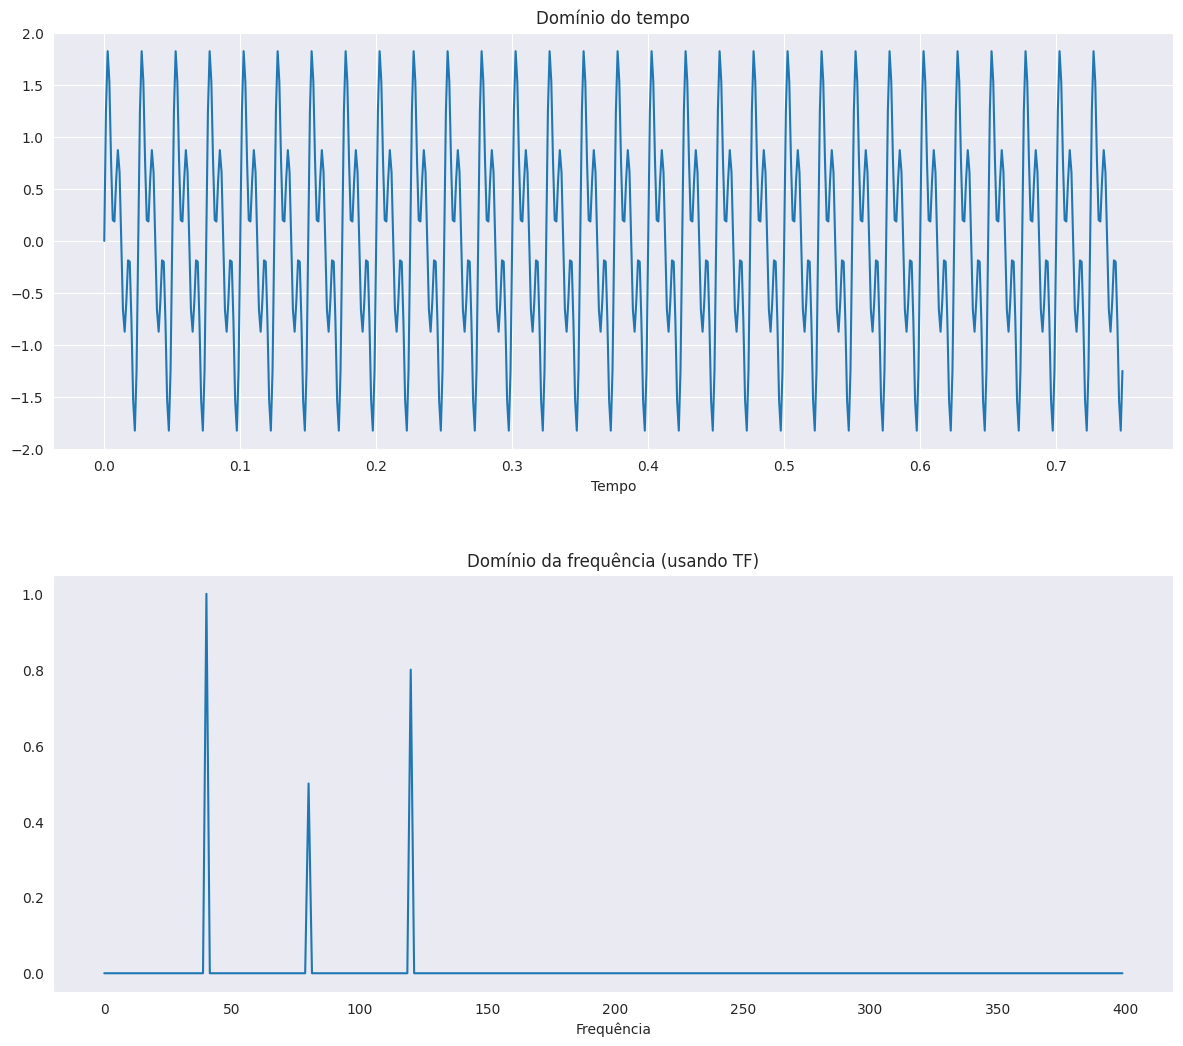

In [8]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(40.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.8*np.sin(120.0 * 2.0*np.pi*x)

yf = rfft(y)
xf = rfftfreq(N, T)[:N//2]

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 12))
ax1.plot(x, y)
ax1.set_xlabel("Tempo")
ax1.set_title("Domínio do tempo", fontsize=12)
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.set_xlabel("Frequência")
ax2.set_title("Domínio da frequência (usando TF)", fontsize=12)

plt.grid()
# plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)
plt.savefig("../images/domínio_tempo_vs_frequência.png")

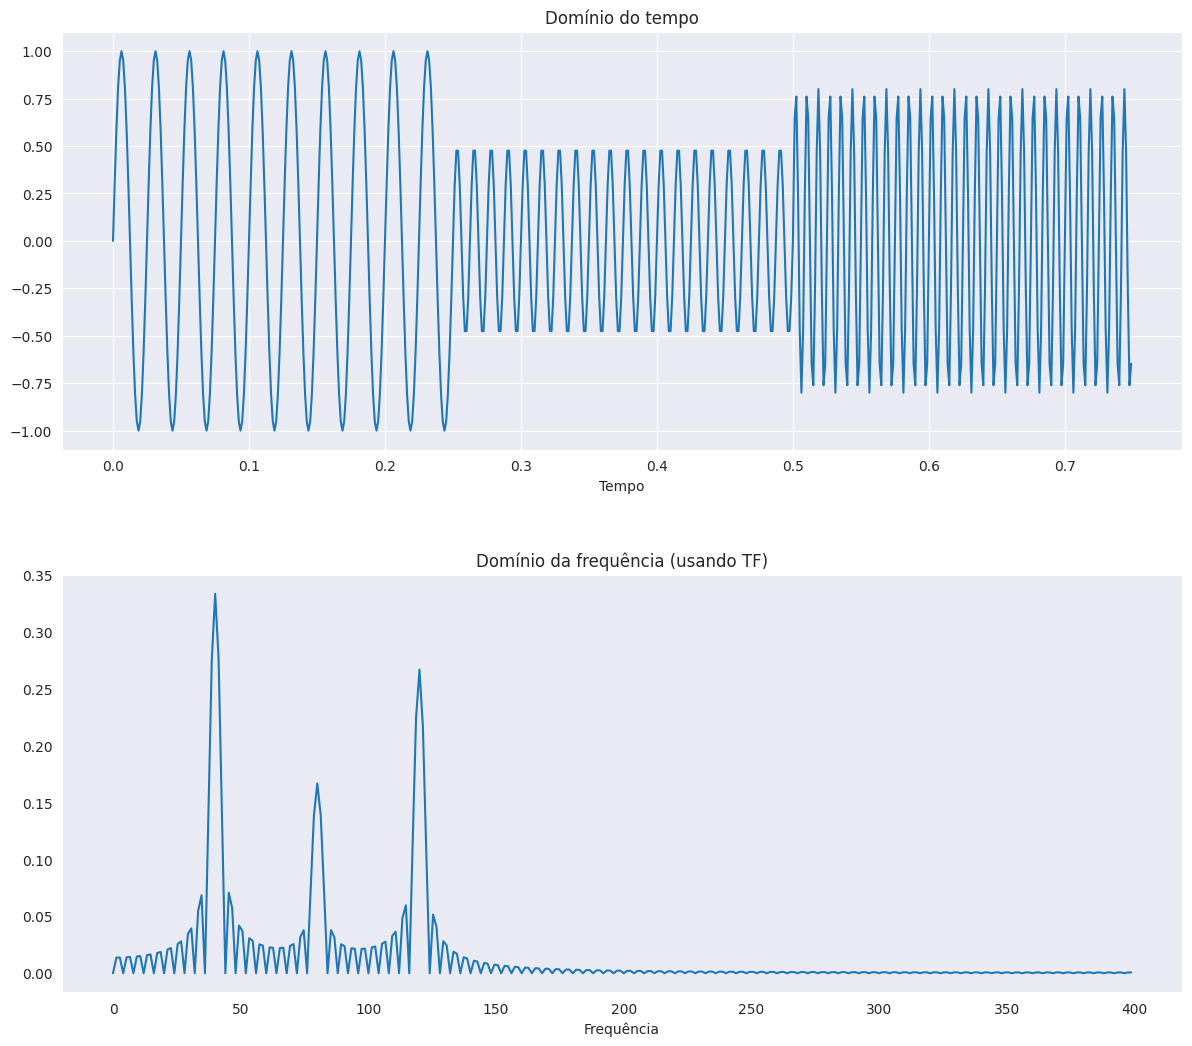

In [9]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N, endpoint=False)
y[:200] = np.sin(40.0 * 2.0*np.pi*x[:200])
y[200:400] = 0.5*np.sin(80.0 * 2.0*np.pi*x[200:400])
y[400:600] = 0.8*np.sin(120.0 * 2.0*np.pi*x[400:600])

yf = rfft(y)
xf = rfftfreq(N, T)[:N//2]

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 12))
ax1.plot(x, y)
ax1.set_xlabel("Tempo")
ax1.set_title("Domínio do tempo", fontsize=12)
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.set_xlabel("Frequência")
ax2.set_title("Domínio da frequência (usando TF)", fontsize=12)

plt.grid()
# plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)
plt.savefig("../images/domínio_tempo_vs_frequência_não-estacionário.png")

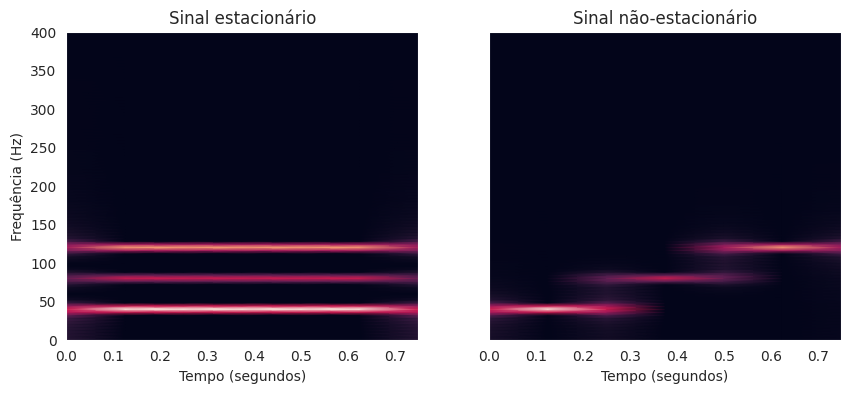

In [11]:
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(40.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.8*np.sin(120.0 * 2.0*np.pi*x)
n_y = []
fft = 200

n_y[:200] = np.sin(40.0 * 2.0*np.pi*x[:200])
n_y[200:400] = 0.5*np.sin(80.0 * 2.0*np.pi*x[200:400])
n_y[400:600] = 0.8*np.sin(120.0 * 2.0*np.pi*x[400:600])

f, t, Zxx = signal.stft(y, 800, nperseg=fft)
n_f, n_t, n_Zxx = signal.stft(n_y, 800, nperseg=fft)

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
axs[0].set_ylabel("Frequência (Hz)")
axs[0].set_xlabel("Tempo (segundos)")
axs[0].set_title("Sinal estacionário")
axs[1].pcolormesh(n_t, n_f, np.abs(n_Zxx), vmin=0, shading='gouraud')
axs[1].set_xlabel("Tempo (segundos)")
axs[1].set_title("Sinal não-estacionário")

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
plt.savefig("../images/comparação_stft.png")

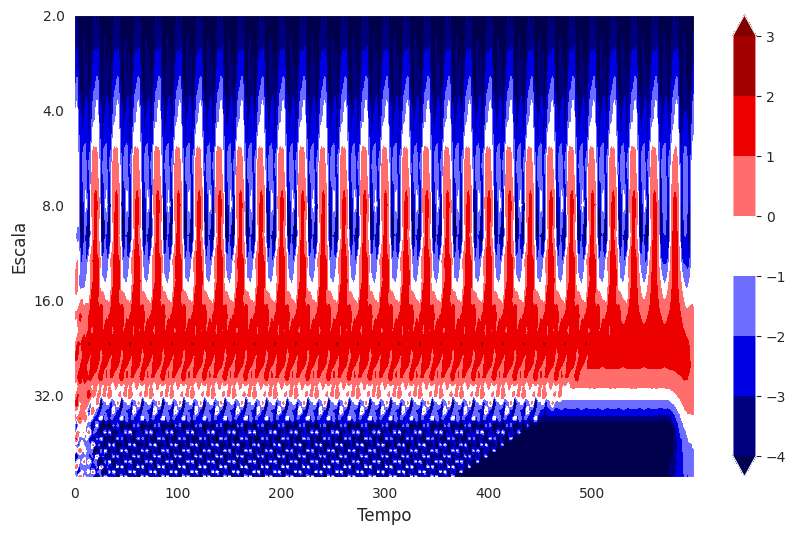

In [12]:
## https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Escala', 
                 xlabel = 'Tempo'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    fig.colorbar(im, orientation="vertical")
    plt.savefig("../images/wavelet.png")
    
N = len(y)
time = np.arange(0, N)
scales = np.arange(1, 30)
plot_wavelet(time, y, scales)

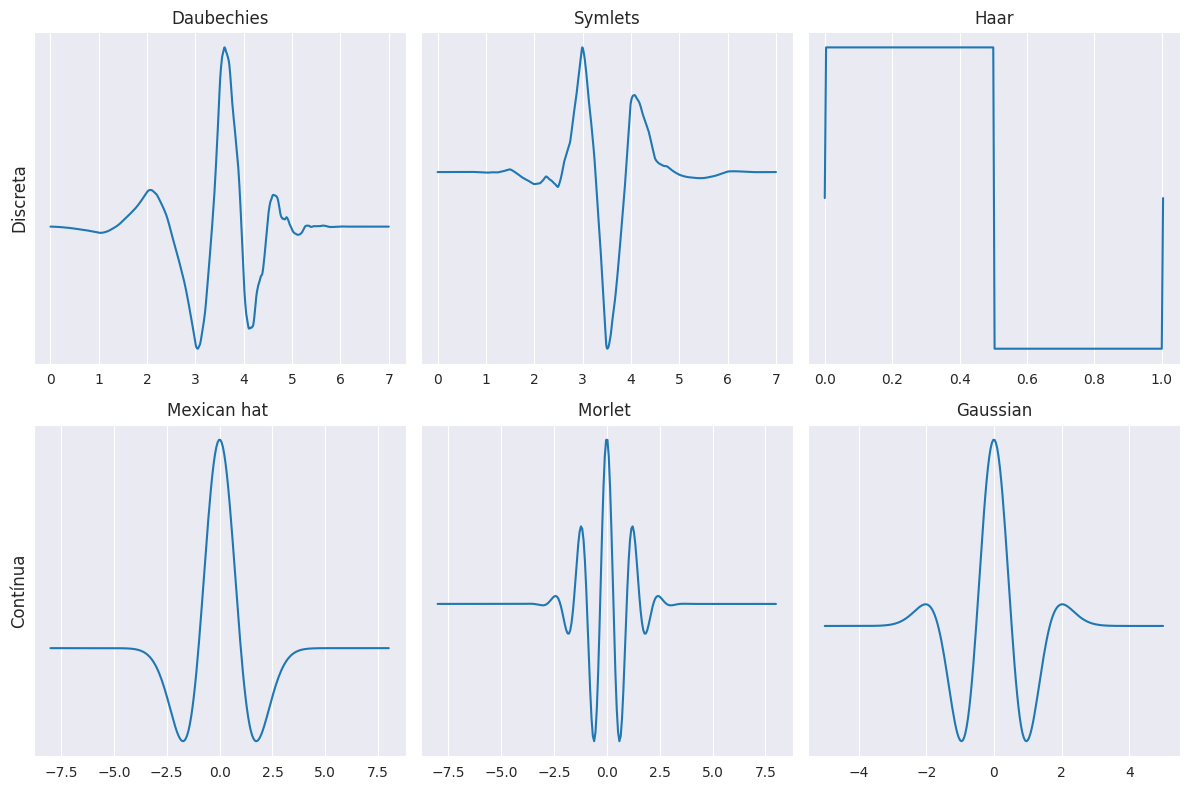

In [13]:
## https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
discrete_wavelets = ['db4', 'sym4', 'haar']
continuous_wavelets = ['mexh', 'morl', 'gaus4']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name.replace("wavelet", "")
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        
        if ii == 0:
            _, wavelet_function, x_values = wavelet.wavefun()
        else:
            wavelet_function, x_values = wavelet.wavefun()
            
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discreta", fontsize=12)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Contínua", fontsize=12)
            
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=12)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.savefig("../images/famílias_wavelet.png")

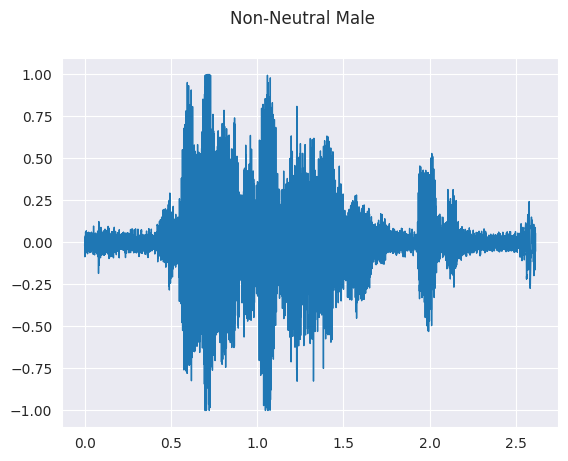

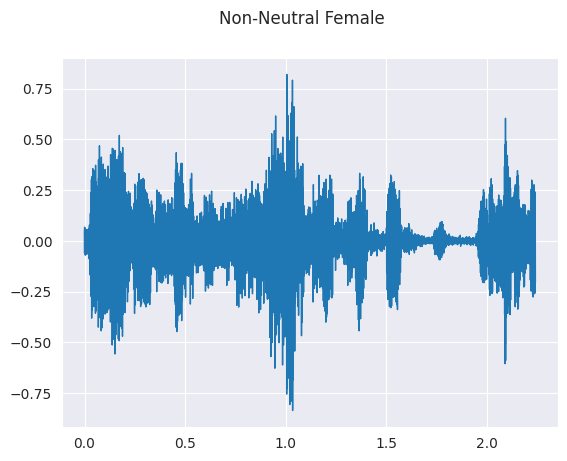

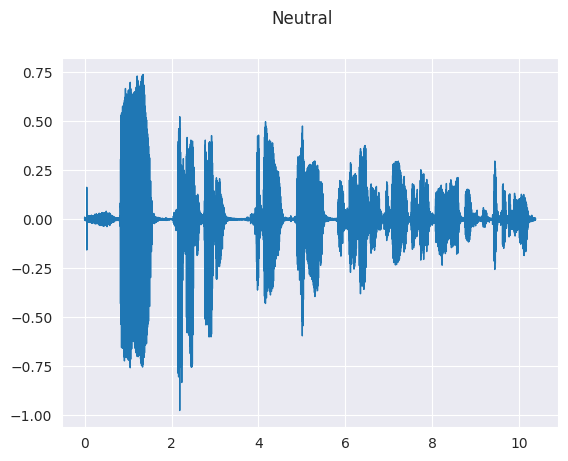

In [14]:
sr = 16000

non_neutral_male_audio, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "non-neutral-male"]["wav_file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)

non_neutral_female_audio, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "non-neutral-female"]["wav_file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)

neutral, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "neutral"]["wav_file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)
                                                                                                     
plot_waveform(non_neutral_male_audio, sr, "Non-Neutral Male")
plot_waveform(non_neutral_female_audio, sr, "Non-Neutral Female")
plot_waveform(neutral, sr, "Neutral")

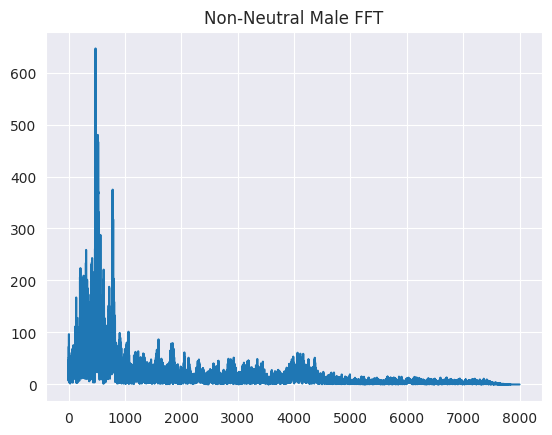

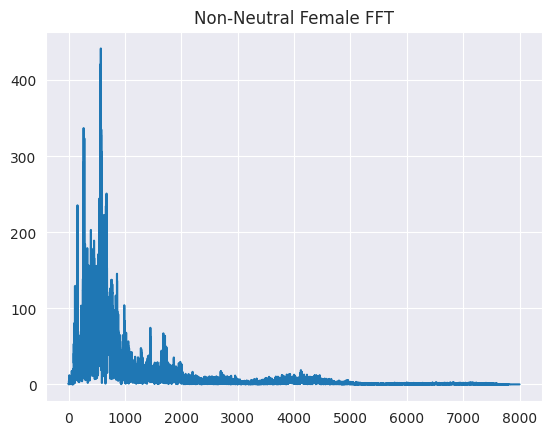

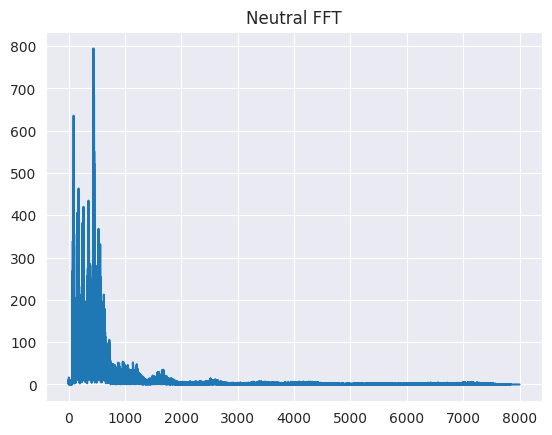

In [15]:
def plot_fft(y, sr, title):
    N = y.shape[0]

    yf = rfft(y)
    xf = rfftfreq(N, 1/sr)

    plt.title(title)
    plt.plot(xf, np.abs(yf))
    plt.show()

sr = 16000
normalizer = Normalize(p=1)

plot_fft(
    normalizer(non_neutral_male_audio.squeeze().numpy(), sr),
    sr,
    "Non-Neutral Male FFT"
)

plot_fft(
    normalizer(non_neutral_female_audio.squeeze().numpy(), sr),
    sr,
    "Non-Neutral Female FFT"
)

plot_fft(
    normalizer(neutral.squeeze().numpy(), sr),
    sr,
    "Neutral FFT"
)

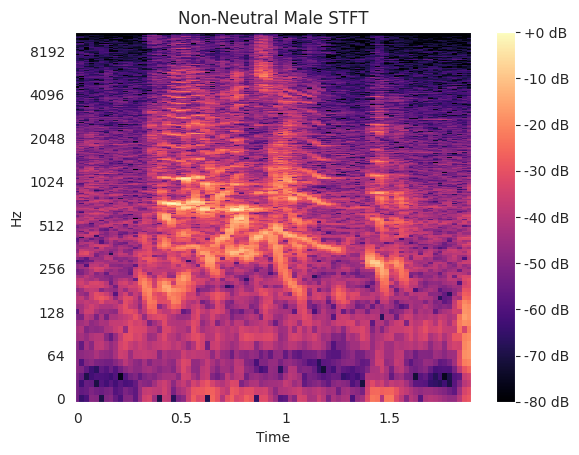

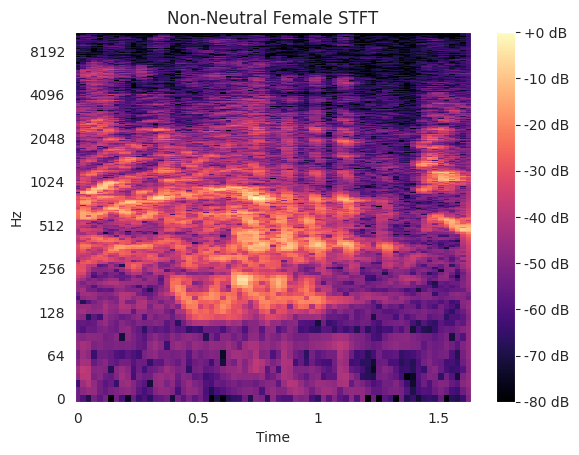

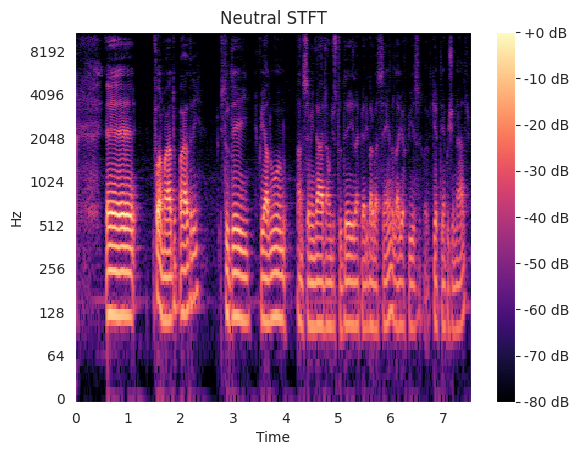

In [16]:
def plot_stft(audio, title):
    fig, ax = plt.subplots()
    S = np.abs(librosa.stft(audio))
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_title(title)
    plt.show()

normalizer = Normalize(p=1)

plot_stft(
    normalizer(non_neutral_male_audio.squeeze().numpy(), sr),
    'Non-Neutral Male STFT'
)

plot_stft(
    normalizer(non_neutral_female_audio.squeeze().numpy(), sr),
    'Non-Neutral Female STFT'
)

plot_stft(
    normalizer(neutral.squeeze().numpy(), sr),
    'Neutral STFT'
)

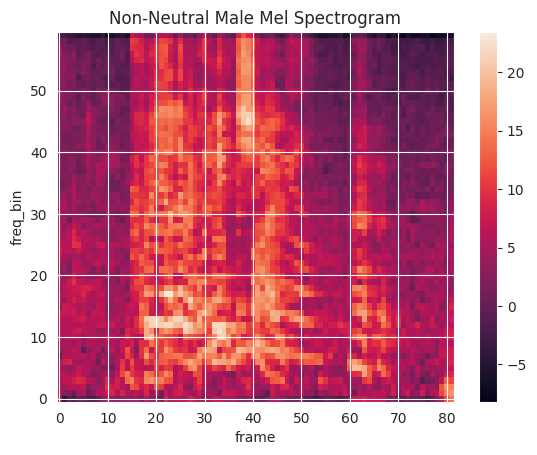

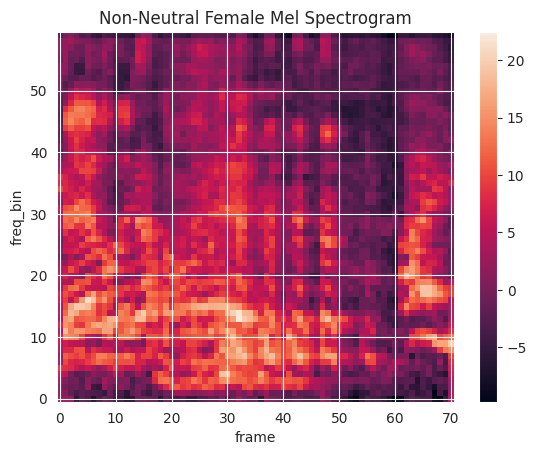

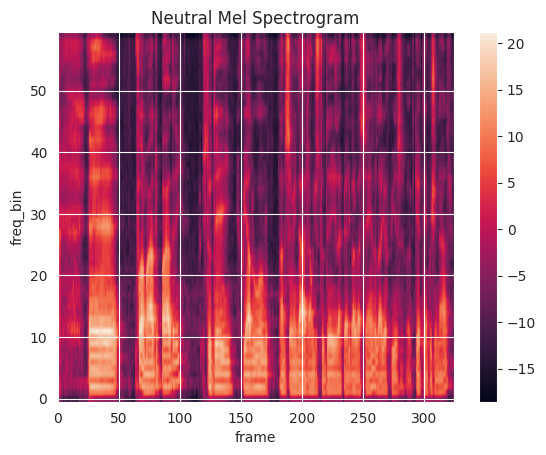

In [17]:
n_fft = 1024
hop_length = 512
n_mels = 60

non_neutral_male_mel_spec = extract_melspectrogram(non_neutral_male_audio, sr, n_fft, hop_length, n_mels).squeeze(0)
non_neutral_female_mel_spec = extract_melspectrogram(non_neutral_female_audio, sr, n_fft, hop_length, n_mels).squeeze(0)
neutral_mel_spec = extract_melspectrogram(neutral, sr, n_fft, hop_length, n_mels).squeeze(0)

plot_spectrogram(
    non_neutral_male_mel_spec,
    "Non-Neutral Male Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

plot_spectrogram(
    non_neutral_female_mel_spec,
    "Non-Neutral Female Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

plot_spectrogram(
    neutral_mel_spec,
    "Neutral Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

In [ ]:
%%time

wavelet_df = wavelet_from_raw_audio(
    df=propor_train_df,
    wavelet="db6",
    maxlevel=3,
    type="packet",
    params={
        "feature":{
            "to_mono": True,
            "sample_rate": sr
        }
    }
)

wavelet_df.head()

In [ ]:
wavelet_df_gby = wavelet_df.groupby("target").agg("mean")
sns.heatmap(wavelet_df_gby, annot=True, fmt=".3f")

In [ ]:
wavelet_df_bin = wavelet_df.replace({"non-neutral-female": "non-neutral", "non-neutral-male": "non-neutral"})
wavelet_df_gby = wavelet_df_bin.groupby("target").agg("mean")
sns.heatmap(wavelet_df_gby, annot=True, fmt=".3f")

In [ ]:
audio = non_neutral_male_audio.squeeze().numpy()
(cA, cD) = pywt.dwt(audio, 'db1')

print(cA, sum(np.multiply(cA, cA))/len(cA))
print(cD, sum(np.multiply(cD, cD))/len(cD))
print()

audio = non_neutral_female_audio.squeeze().numpy()
(cA, cD) = pywt.dwt(audio, 'db1')

print(cA, sum(np.multiply(cA, cA))/len(cA))
print(cD, sum(np.multiply(cD, cD))/len(cD))
print()

audio = neutral.squeeze().numpy()
(cA, cD) = pywt.dwt(audio, 'db1')

print(cA, sum(np.multiply(cA, cA))/len(cA))
print(cD, sum(np.multiply(cD, cD))/len(cD))
print()

In [ ]:
spec = non_neutral_male_mel_spec.squeeze().numpy()

coeffs = pywt.wavedecn(spec, wavelet='db6', level=3)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plot_wavelet(
    arr,
    "Non-Neutral Male Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

spec = non_neutral_female_mel_spec.squeeze().numpy()

coeffs = pywt.wavedecn(spec, wavelet='db6', level=3)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plot_wavelet(
    arr,
    "Non-Neutral Female Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

spec = neutral_mel_spec.squeeze().numpy()

coeffs = pywt.wavedecn(spec, wavelet='db6', level=3)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plot_wavelet(
    arr,
    "Neutral Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

In [ ]:
from pytorch_wavelets import ScatLayer

X = non_neutral_male_mel_spec.unsqueeze(0).unsqueeze(0)
scat = ScatLayer()
Y = scat(X)
print(Y.shape)